# pfceval | Detailed evaluation template

This notebooks shows how to do a detailed evaluation for two synthetic forecasts.

### Prepare Evaluation reports

In [1]:
import pfceval
import polars as pl

from dataclasses import dataclass

@dataclass
class DetailedEvalConfig():
    index_cols = ["valid_time", "station_id", "step"]
    eval_ths = [14, 15, 16, 17]
    save_dir = "."
    lead_time_col = "step"
    location_id_col = "station_id"
    ensemble_prefix = "pred_q"
    obs_col = "wind_speed"
    bootstrap_col = "run_id"
    n_bootstrap_iter = 100
    rank_histogram_bins = 10
    CI = 0.9

    construct_eval_reports = True

config = DetailedEvalConfig()


def get_detailed_evaluation_report(forecast, experiment_name):

    calc = pfceval.Calculator(forecast, config.index_cols)
    calc.add_absolute_error()
    calc.add_squared_error()
    # Add probabilistic metrics
    calc.add_variance()
    calc.add_crps()
    # Add threshold based metrics
    for th in config.eval_ths:
        calc.add_twcrps(th)
        calc.add_brier(th)

    # fill_evaluation is a quick way to create an Evaluation.
    # Custom evaluations also can be done without using it.
    report = pfceval.Evaluation.fill_evaluation(
        experiment_name=experiment_name,
        calculator=calc,
        lead_time_col=config.lead_time_col,
        location_id_col=config.location_id_col,
        bootstrap=True,
        n_iter=config.n_bootstrap_iter,
        CI=config.CI,
        location_metrics=True,
    )

    for th in config.eval_ths:
        report.add_brier_decomp(
            calculator=calc,
            th=th,
            n_iter=config.n_bootstrap_iter,
            CI=config.CI
        )

    report.add_rank_histogram(
        calculator=calc,
        n_bins=config.rank_histogram_bins,
    )

    return report

# Generate synthetic forecasts
forecast_paths = pfceval.utils.get_example_forecast_paths()

exp_names = []
for i, forecast_path in enumerate(forecast_paths):
    forecast = pfceval.Forecast(
        fc_path=forecast_path,
        ensemble_prefix=config.ensemble_prefix,
        obs_col=config.obs_col,
        bootstrap_cols=config.bootstrap_col,
        load_to_memory=True
    )

    exp_name = f"DetailedEvaluationTemplate_{i}"
    exp_names.append(exp_name)
    report = get_detailed_evaluation_report(
        forecast=forecast,
        experiment_name=exp_name
    )
    # Get metrics for the stations that is not present the training data
    unseen_report = get_detailed_evaluation_report(
        forecast=forecast.filter(pl.col("unseen_sta") == True),
        experiment_name=exp_name
    )
    # Get a common report for all filters by combining them
    # The reports on right will have the right_prefix in their tables
    report.extend(unseen_report, right_prefix="unseen")
    # Save the report to disk
    report.save_results(f"{config.save_dir}/{exp_name}")

In [2]:
forecast.forecast

model_time,station_id,step,unseen_sta,latitude,longitude,run_id,valid_time,wind_speed,pred_q0,pred_q1,pred_q2,pred_q3,pred_q4,pred_q5,pred_q6,pred_q7,pred_q8,pred_q9,pred_q10,pred_q11,pred_q12,pred_q13,pred_q14,pred_q15,pred_q16,pred_q17,pred_q18,pred_q19,mean_pred,_bootstrap
datetime[μs],i64,duration[μs],bool,f64,f64,i64,datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
2022-01-02 00:00:00,101,1h,true,52.11,5.18,0,2022-01-02 01:00:00,12.101843,10.913838,10.988207,11.062576,11.136945,11.211314,11.285683,11.360053,11.434422,11.508791,11.58316,11.657529,11.731899,11.806268,11.880637,11.955006,12.029375,12.103745,12.178114,12.252483,12.326852,11.620345,"""0"""
2022-01-02 00:00:00,101,2h,true,52.11,5.18,0,2022-01-02 02:00:00,16.012467,16.210771,16.256207,16.301643,16.347078,16.392514,16.43795,16.483386,16.528822,16.574258,16.619694,16.66513,16.710566,16.756002,16.801437,16.846873,16.892309,16.937745,16.983181,17.028617,17.074053,16.642412,"""0"""
2022-01-02 00:00:00,101,3h,true,52.11,5.18,0,2022-01-02 03:00:00,12.713361,11.9418,12.011136,12.080472,12.149807,12.219143,12.288479,12.357815,12.427151,12.496486,12.565822,12.635158,12.704494,12.773829,12.843165,12.912501,12.981837,13.051173,13.120508,13.189844,13.25918,12.60049,"""0"""
2022-01-02 00:00:00,101,4h,true,52.11,5.18,0,2022-01-02 04:00:00,15.210753,13.970119,14.026554,14.08299,14.139425,14.19586,14.252295,14.30873,14.365165,14.4216,14.478036,14.534471,14.590906,14.647341,14.703776,14.760211,14.816646,14.873082,14.929517,14.985952,15.042387,14.506253,"""0"""
2022-01-02 00:00:00,101,5h,true,52.11,5.18,0,2022-01-02 05:00:00,17.588675,17.652856,17.728393,17.80393,17.879467,17.955004,18.030541,18.106078,18.181615,18.257152,18.332689,18.408227,18.483764,18.559301,18.634838,18.710375,18.785912,18.861449,18.936986,19.012523,19.08806,18.370458,"""0"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-04-11 00:00:00,105,10h,false,51.75,4.54,99,2022-04-11 10:00:00,16.304457,16.24241,16.320557,16.398705,16.476852,16.554999,16.633147,16.711294,16.789442,16.867589,16.945736,17.023884,17.102031,17.180179,17.258326,17.336473,17.414621,17.492768,17.570916,17.649063,17.72721,16.98481,"""99"""
2022-04-11 00:00:00,105,11h,false,51.75,4.54,99,2022-04-11 11:00:00,19.530781,18.437366,18.524706,18.612047,18.699387,18.786727,18.874068,18.961408,19.048748,19.136089,19.223429,19.31077,19.39811,19.48545,19.572791,19.660131,19.747471,19.834812,19.922152,20.009493,20.096833,19.267099,"""99"""
2022-04-11 00:00:00,105,12h,false,51.75,4.54,99,2022-04-11 12:00:00,13.839804,12.771712,12.873232,12.974752,13.076273,13.177793,13.279313,13.380833,13.482353,13.583874,13.685394,13.786914,13.888434,13.989954,14.091475,14.192995,14.294515,14.396035,14.497555,14.599076,14.700596,13.736154,"""99"""


### Load the evaluation reports and analyze 

The begining is the same with basic evaluation but detailed one also includes rank histograms, reliability plots and brier decomposition

In [3]:
# Read reports from location
reports = [pfceval.Evaluation.load_report(f"./{path}") for path in exp_names]

overall = pfceval.plotting.stack_overall_metrics(*reports)
overall.sort("mae")

experiment,twcrps_th:14,twcrps_th:15,crps,mse,brier_th:14,brier_th:15,twcrps_th:16,brier_th:16,brier_th:17,variance,twcrps_th:17,mae
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""DetailedEvaluationTemplate_0""",0.1836,0.132635,0.269436,0.217405,0.044715,0.052999,0.082701,0.045669,0.030219,0.209965,0.043749,0.397419
"""DetailedEvaluationTemplate_1""",0.207571,0.150023,0.302175,0.269097,0.050571,0.05971,0.093528,0.051871,0.033291,0.209441,0.050322,0.442332


In [4]:
unseen_overall = pfceval.plotting.stack_overall_metrics(*reports, table_name="unseen_overall_metrics")
unseen_overall.sort("mae")

experiment,twcrps_th:14,twcrps_th:15,crps,mse,brier_th:14,brier_th:15,twcrps_th:16,brier_th:16,brier_th:17,variance,twcrps_th:17,mae
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""DetailedEvaluationTemplate_0""",0.183214,0.130303,0.272317,0.222476,0.050413,0.054047,0.081882,0.042371,0.031976,0.208617,0.044497,0.403267
"""DetailedEvaluationTemplate_1""",0.206885,0.147435,0.302778,0.270622,0.054838,0.059779,0.0908,0.050703,0.032014,0.209006,0.049228,0.443171


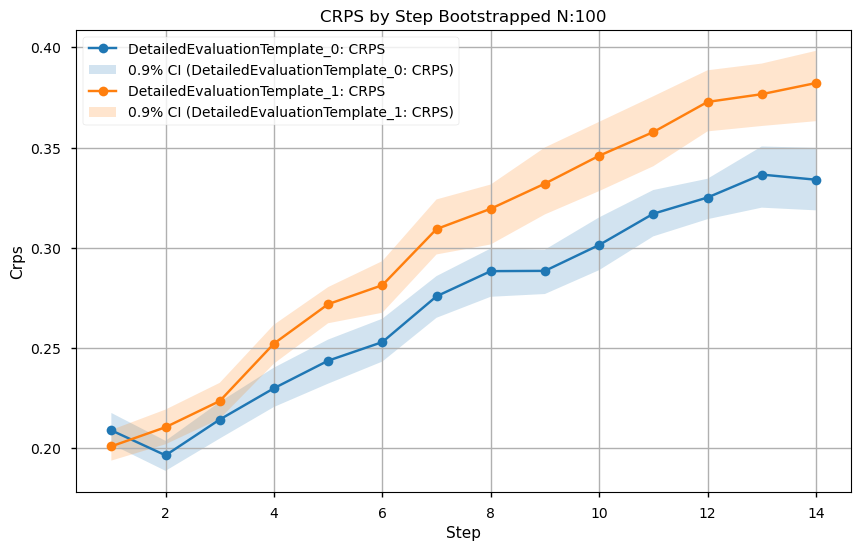

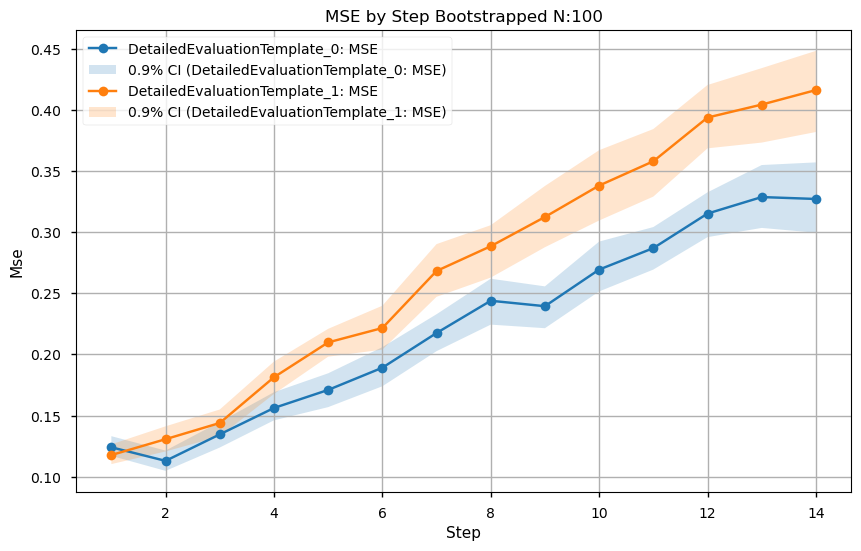

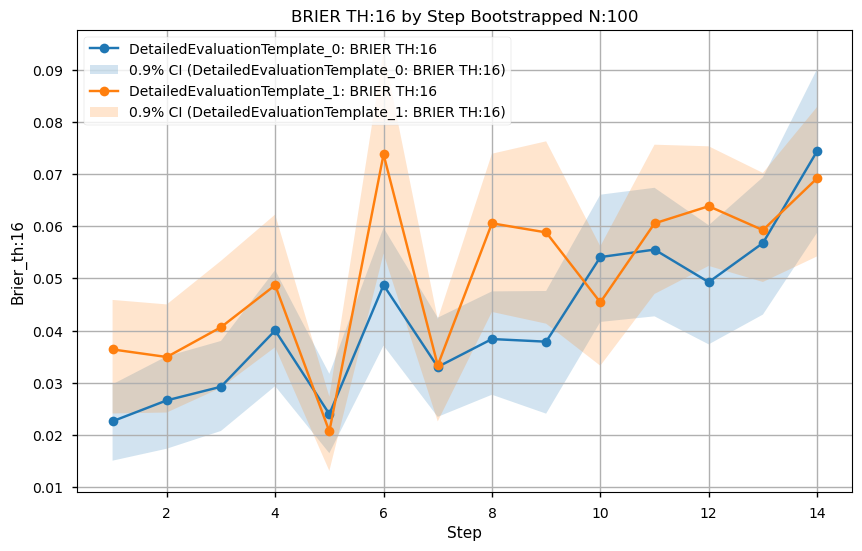

In [5]:
pfceval.plotting.plot_lead_time_metrics(*reports, table_name="unseen_bootstraped_lead_time_metrics", metrics=["crps", "mse", "brier_th:16"])

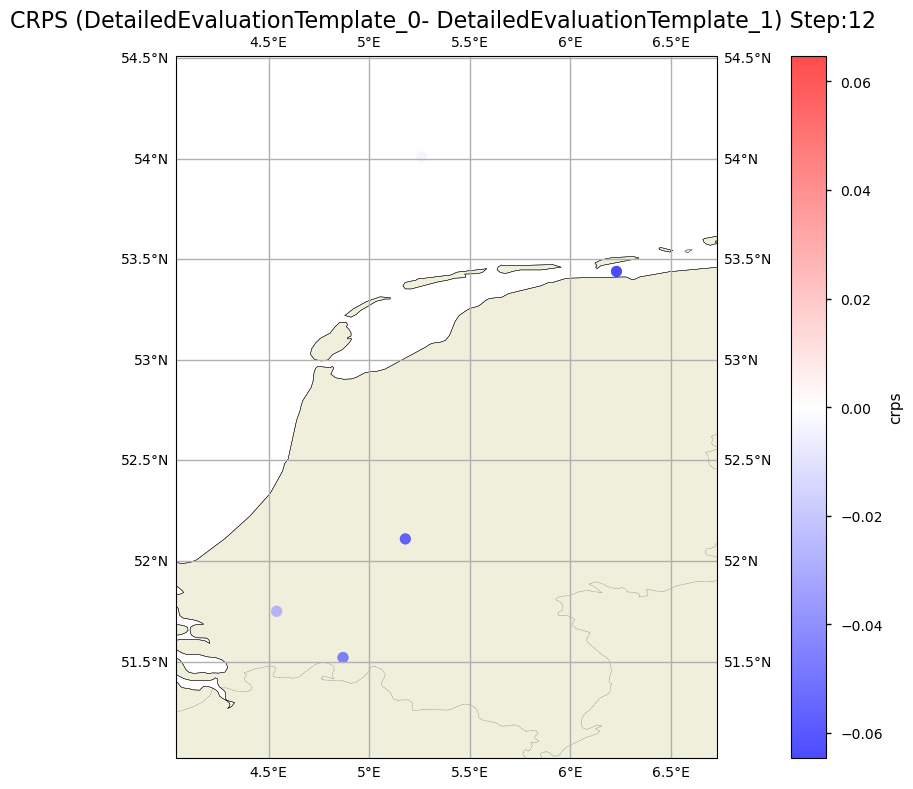

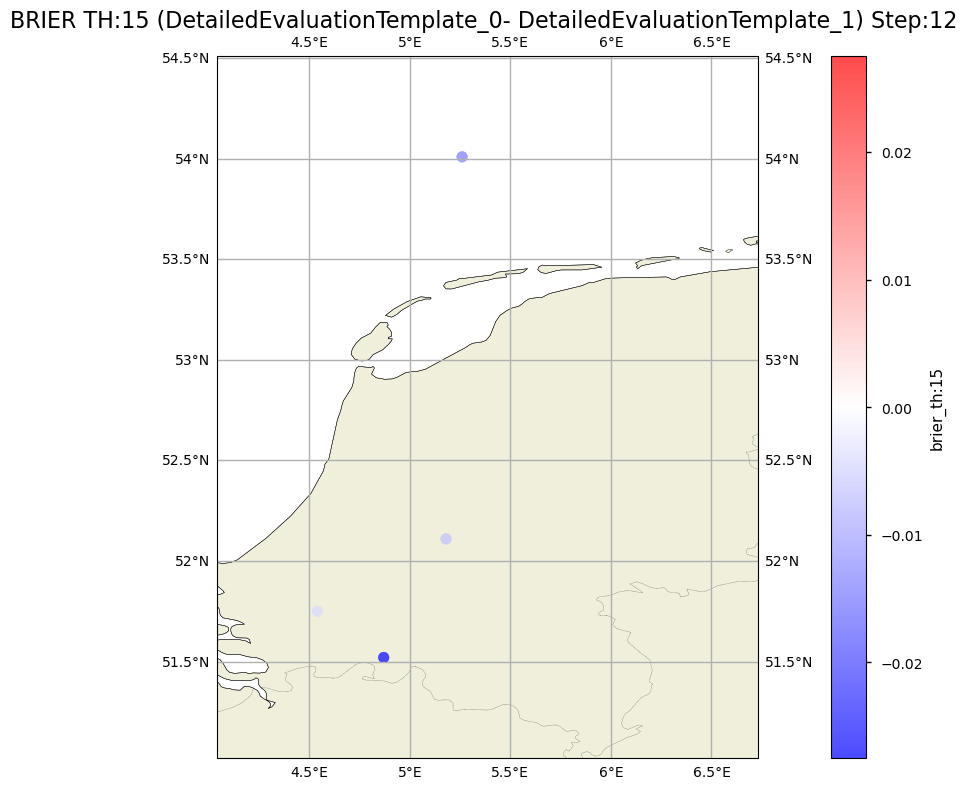

In [6]:
pfceval.plotting.plot_location_metrics(
    step=12,
    evaluation=reports[0],
    compare_with=reports[1],
    metrics=["crps", "brier_th:15"],
    cmap="bwr",
    dot_size=60,
    tol=0.5,
)

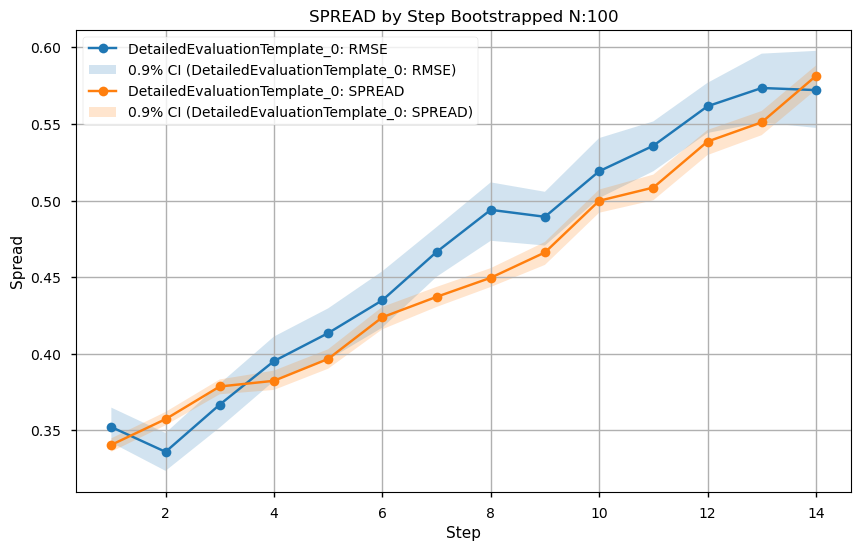

In [7]:
pfceval.plotting.plot_spread_rmse(reports[0], table_name="unseen_bootstraped_lead_time_metrics")

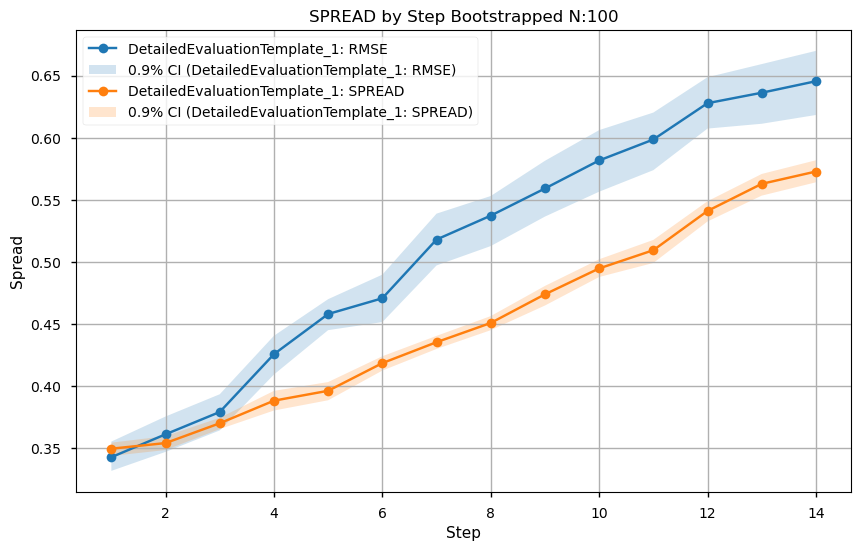

In [8]:
pfceval.plotting.plot_spread_rmse(reports[1], table_name="unseen_bootstraped_lead_time_metrics")

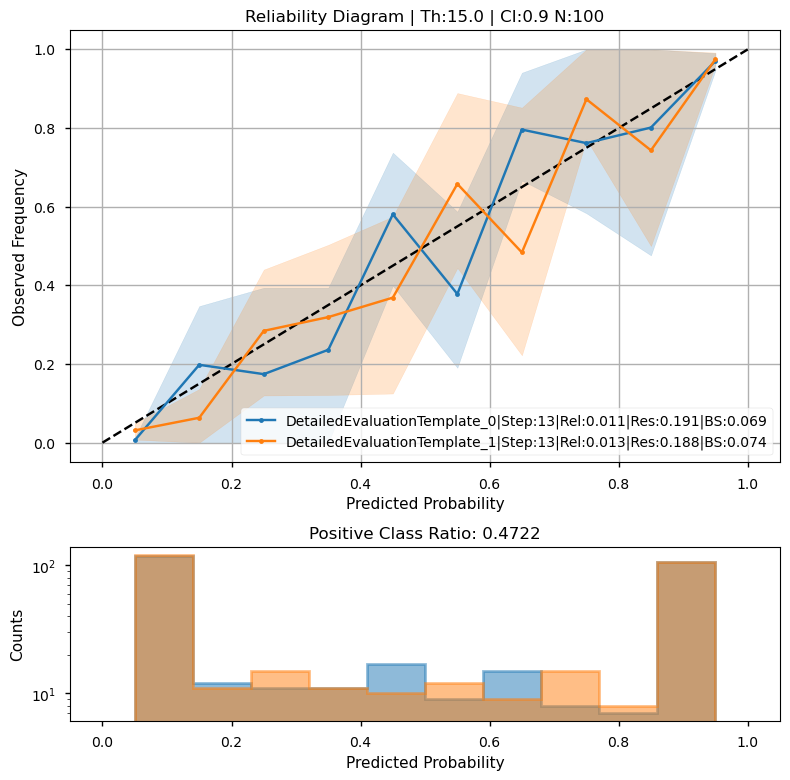

In [9]:
pfceval.plotting.plot_reliability_diagram(*reports, step=13, table_name="bootstrapped_obs_bar_th:15", nbins=10)

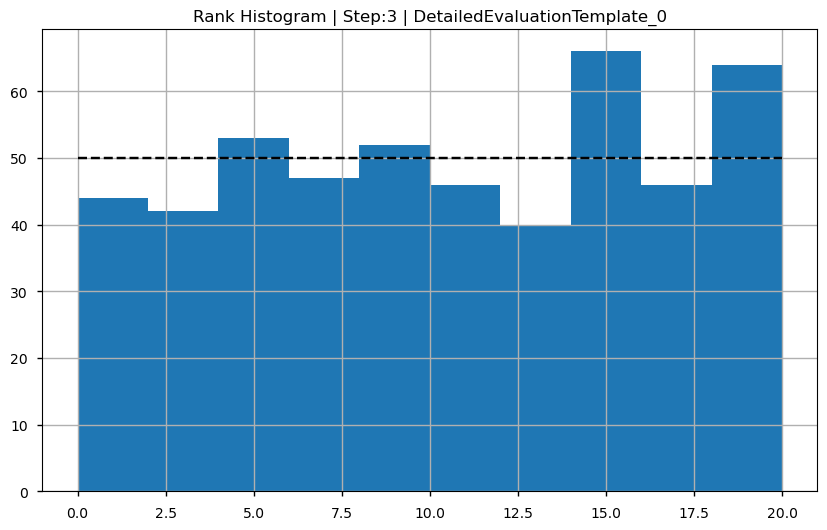

In [10]:
pfceval.plotting.plot_rank_histogram(reports[0], step=3)

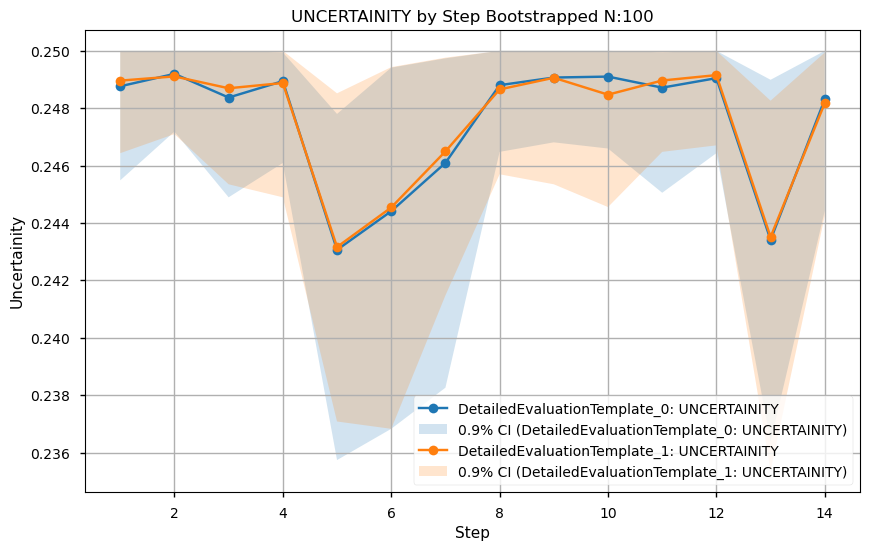

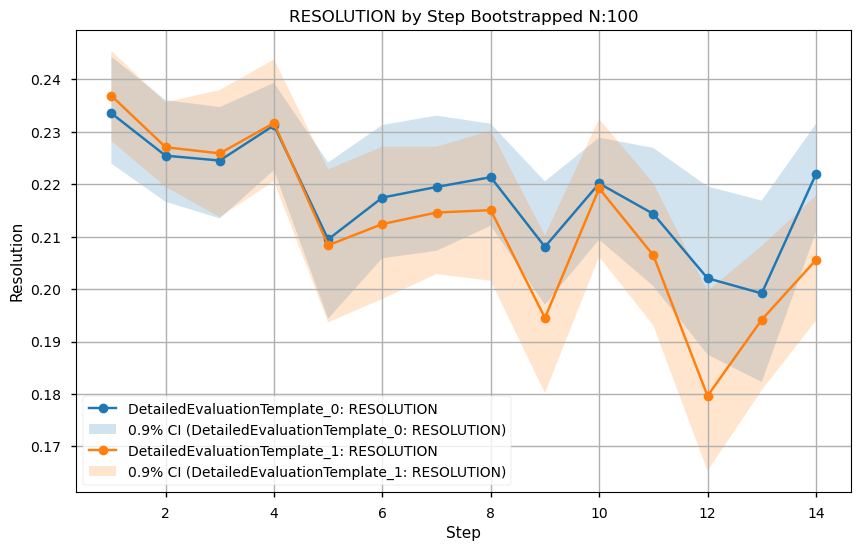

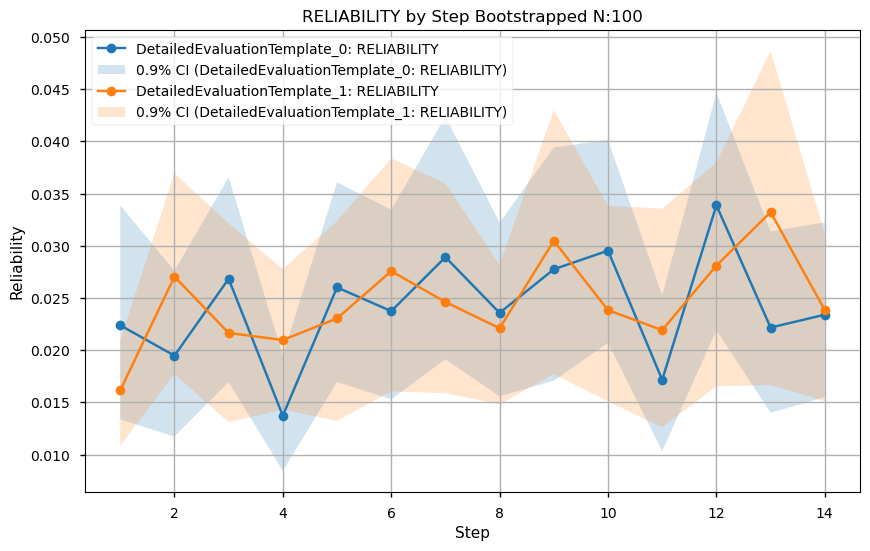

In [11]:
pfceval.plotting.plot_lead_time_metrics(*reports, table_name="unseen_bootstrapped_brier_decomp_th:15")

In [12]:
reports[0].tables()

['overall_metrics',
 'lead_time_metrics',
 'lead_time_location_metrics',
 'station_meta',
 'bootstraped_lead_time_metrics',
 'bootstrapped_brier_decomp_th:14',
 'bootstrapped_obs_bar_th:14',
 'bootstrapped_brier_decomp_th:15',
 'bootstrapped_obs_bar_th:15',
 'bootstrapped_brier_decomp_th:16',
 'bootstrapped_obs_bar_th:16',
 'bootstrapped_brier_decomp_th:17',
 'bootstrapped_obs_bar_th:17',
 'lead_time_rank_histogram',
 'unseen_overall_metrics',
 'unseen_lead_time_metrics',
 'unseen_lead_time_location_metrics',
 'unseen_station_meta',
 'unseen_bootstraped_lead_time_metrics',
 'unseen_bootstrapped_brier_decomp_th:14',
 'unseen_bootstrapped_obs_bar_th:14',
 'unseen_bootstrapped_brier_decomp_th:15',
 'unseen_bootstrapped_obs_bar_th:15',
 'unseen_bootstrapped_brier_decomp_th:16',
 'unseen_bootstrapped_obs_bar_th:16',
 'unseen_bootstrapped_brier_decomp_th:17',
 'unseen_bootstrapped_obs_bar_th:17',
 'unseen_lead_time_rank_histogram']